# Transformer
:label:`sec_transformer`

 :numref:`subsec_cnn-rnn-self-attention`中比较了卷积神经网络（CNN）、循环神经网络（RNN）和自注意力（self-attention）。值得注意的是，自注意力同时具有并行计算和最短的最大路径长度这两个优势。因此，使用自注意力来设计深度架构是很有吸引力的。对比之前仍然依赖循环神经网络实现输入表示的自注意力模型 :cite:`Cheng.Dong.Lapata.2016,Lin.Feng.Santos.ea.2017,Paulus.Xiong.Socher.2017`，Transformer模型完全基于注意力机制，没有任何卷积层或循环神经网络层 :cite:`Vaswani.Shazeer.Parmar.ea.2017`。尽管Transformer最初是应用于在文本数据上的序列到序列学习，但现在已经推广到各种现代的深度学习中，例如语言、视觉、语音和强化学习领域。

## 模型

Transformer作为编码器－解码器架构的一个实例，其整体架构图在 :numref:`fig_transformer`中展示。正如所见到的，Transformer是由编码器和解码器组成的。与 :numref:`fig_s2s_attention_details`中基于Bahdanau注意力实现的序列到序列的学习相比，Transformer的编码器和解码器是基于自注意力的模块叠加而成的，源（输入）序列和目标（输出）序列的*嵌入*（embedding）表示将加上*位置编码*（positional encoding），再分别输入到编码器和解码器中。

![transformer架构](../img/transformer.svg)
:width:`500px`
:label:`fig_transformer`

图 :numref:`fig_transformer`中概述了Transformer的架构。从宏观角度来看，Transformer的编码器是由多个相同的层叠加而成的，每个层都有两个子层（子层表示为$\mathrm{sublayer}$）。第一个子层是*多头自注意力*（multi-head self-attention）汇聚；第二个子层是*基于位置的前馈网络*（positionwise feed-forward network）。具体来说，在计算编码器的自注意力时，查询、键和值都来自前一个编码器层的输出。受 :numref:`sec_resnet`中残差网络的启发，每个子层都采用了*残差连接*（residual connection）。在Transformer中，对于序列中任何位置的任何输入$\mathbf{x} \in \mathbb{R}^d$，都要求满足$\mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$，以便残差连接满足$\mathbf{x} + \mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$。在残差连接的加法计算之后，紧接着应用*层规范化*（layer normalization） :cite:`Ba.Kiros.Hinton.2016`。因此，输入序列对应的每个位置，Transformer编码器都将输出一个$d$维表示向量。

Transformer解码器也是由多个相同的层叠加而成的，并且层中使用了残差连接和层规范化。除了编码器中描述的两个子层之外，解码器还在这两个子层之间插入了第三个子层，称为*编码器－解码器注意力*（encoder-decoder attention）层。在编码器－解码器注意力中，查询来自前一个解码器层的输出，而键和值来自整个编码器的输出。在解码器自注意力中，查询、键和值都来自上一个解码器层的输出。但是，解码器中的每个位置只能考虑该位置之前的所有位置。这种*掩蔽*（masked）注意力保留了*自回归*（auto-regressive）属性，确保预测仅依赖于已生成的输出词元。

在此之前已经描述并实现了基于缩放点积多头注意力 :numref:`sec_multihead-attention`和位置编码 :numref:`subsec_positional-encoding`。接下来将实现Transformer模型的剩余部分。


In [21]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## [**基于位置的前馈网络**]

基于位置的前馈网络对序列中的所有位置的表示进行变换时使用的是同一个多层感知机（MLP），这就是称前馈网络是*基于位置的*（positionwise）的原因。在下面的实现中，输入`X`的形状（批量大小，时间步数或序列长度，隐单元数或特征维度）将被一个两层的感知机转换成形状为（批量大小，时间步数，`ffn_num_outputs`）的输出张量。


In [22]:
#@save
# 定义了一个名为PositionWiseFFN的类，继承自nn.Module。
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    # 在__init__方法中，初始化位置编码器的参数。
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        # 创建一个线性层self.dense1，输入维度为ffn_num_input，输出维度为ffn_num_hiddens。
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        # 创建一个ReLU激活函数实例self.relu。
        self.relu = nn.ReLU()
        # 创建一个线性层self.dense2，输入维度为ffn_num_hiddens，输出维度为ffn_num_outputs。
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    # 在forward方法中，定义了前向传播的过程
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

下面的例子显示，[**改变张量的最里层维度的尺寸**]，会改变成基于位置的前馈网络的输出尺寸。因为用同一个多层感知机对所有位置上的输入进行变换，所以当所有这些位置的输入相同时，它们的输出也是相同的。


In [23]:
# 创建一个名为ffn的PositionWiseFFN实例，传入参数为ffn_num_input=4、ffn_num_hiddens=4和ffn_num_outputs=8。
ffn = PositionWiseFFN(4, 4, 8)
# 将ffn设置为评估模式，即调用ffn.eval()。
ffn.eval()
# 创建一个形状为(2, 3, 4)的张量X，元素值都为1。
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.4704,  0.1533,  0.4484, -0.5957,  0.1779, -0.4064,  0.0604,  0.2604],
        [ 0.4704,  0.1533,  0.4484, -0.5957,  0.1779, -0.4064,  0.0604,  0.2604],
        [ 0.4704,  0.1533,  0.4484, -0.5957,  0.1779, -0.4064,  0.0604,  0.2604]],
       grad_fn=<SelectBackward0>)

## 残差连接和层规范化

现在让我们关注 :numref:`fig_transformer`中的*加法和规范化*（add&norm）组件。正如在本节开头所述，这是由残差连接和紧随其后的层规范化组成的。两者都是构建有效的深度架构的关键。

 :numref:`sec_batch_norm`中解释了在一个小批量的样本内基于批量规范化对数据进行重新中心化和重新缩放的调整。层规范化和批量规范化的目标相同，但层规范化是基于特征维度进行规范化。尽管批量规范化在计算机视觉中被广泛应用，但在自然语言处理任务中（输入通常是变长序列）批量规范化通常不如层规范化的效果好。

以下代码[**对比不同维度的层规范化和批量规范化的效果**]。


In [24]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


现在可以[**使用残差连接和层规范化**]来实现`AddNorm`类。暂退法也被作为正则化方法使用。


In [25]:
#@save
# 定义了一个名为AddNorm的类，它是nn.Module的子类。
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    # 定义了类的构造函数。它接受三个参数：normalized_shape表示要规范化的张量的形状，dropout表示要应用的dropout率，**kwargs表示其他关键字参数。
    def __init__(self, normalized_shape, dropout, **kwargs):
        # 调用父类nn.Module的构造函数，以确保正确地初始化该模块。
        super(AddNorm, self).__init__(**kwargs)
        # 创建一个nn.Dropout对象，并将其赋值给实例变量self.dropout。这将在前向传播过程中应用dropout。
        self.dropout = nn.Dropout(dropout)
        # 创建一个nn.LayerNorm对象，并将其赋值给实例变量self.ln。这将对输入进行层规范化。
        self.ln = nn.LayerNorm(normalized_shape)

#  定义了前向传播函数。它接受两个输入张量X和Y。
    def forward(self, X, Y):
        # 在前向传播中，首先对Y应用dropout，然后将结果与X相加。最后，将得到的张量应用层规范化(ln)并返回结果。
        return self.ln(self.dropout(Y) + X)

残差连接要求两个输入的形状相同，以便[**加法操作后输出张量的形状相同**]。


In [26]:
# - 创建一个名为add_norm的AddNorm类的实例。传入的参数是[3, 4]，表示要规范化的张量的形状是3行4列，另外还传入了0.5作为dropout率。
add_norm = AddNorm([3, 4], 0.5)
# 将add_norm模型设置为评估模式。在评估模式下，模型的行为会发生变化，例如在前向传播时不会应用dropout。
add_norm.eval()
#  调用add_norm模型的前向传播方法，传入两个输入张量。第一个输入张量是形状为(2, 3, 4)的全1张量，表示一个大小为2的批次中每个样本的形状为(3, 4)。第二个输入张量的形状与第一个相同。
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

## 编码器

有了组成Transformer编码器的基础组件，现在可以先[**实现编码器中的一个层**]。下面的`EncoderBlock`类包含两个子层：多头自注意力和基于位置的前馈网络，这两个子层都使用了残差连接和紧随的层规范化。


In [27]:
# 该模块的作用是实现Transformer编码器块的前向传播逻辑。它包括多头注意力机制和位置编码前馈神经网络，并在它们之间使用残差连接和层规范化。
#@save
# 定义了一个名为EncoderBlock的类，它是nn.Module的子类。
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    # 定义了类的构造函数。它接受多个参数，包括key_size，query_size，value_size等，用于指定Transformer编码器块的各个部分的大小和配置。
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        # 调用父类nn.Module的构造函数，以确保正确地初始化该模块。
        super(EncoderBlock, self).__init__(**kwargs)
        # 创建一个d2l.MultiHeadAttention对象，并将其赋值给实例变量self.attention。这是一个多头注意力机制。
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        # 创建一个AddNorm对象，并将其赋值给实例变量self.addnorm1。它是一个残差连接后进行层规范化的模块。
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # 创建一个PositionWiseFFN对象，并将其赋值给实例变量self.ffn。这是一个位置编码前馈神经网络。
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        # 创建一个AddNorm对象，并将其赋值给实例变量self.addnorm2。它是另一个残差连接后进行层规范化的模块。
        self.addnorm2 = AddNorm(norm_shape, dropout)

    # 定义了前向传播函数。它接受两个输入参数：X表示输入张量，valid_lens表示有效长度的张量。
    def forward(self, X, valid_lens):
        # 在前向传播中，首先通过多头注意力机制self.attention对输入张量X进行处理，然后将结果与输入张量X相加，并应用层规范化(addnorm1)。
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        #  将前一步得到的结果Y通过位置编码前馈神经网络self.ffn进行处理，然后将结果与Y相加，并应用层规范化(addnorm2)。最后返回结果。
        return self.addnorm2(Y, self.ffn(Y))

正如从代码中所看到的，[**Transformer编码器中的任何层都不会改变其输入的形状**]。


In [28]:
# 创建一个大小为(2, 100, 24)的全1张量，并将其赋值给变量X。这个张量表示一个大小为2的批次，每个样本的形状是(100, 24)。
X = torch.ones((2, 100, 24))
# 创建一个大小为2的张量valid_lens，其中包含有效长度的值。这意味着在批次中，第一个样本有3个有效元素，第二个样本有2个有效元素。
valid_lens = torch.tensor([3, 2])
# 创建一个名为encoder_blk的EncoderBlock实例。
# 传入的参数为每个部分的大小和配置，其中24表示键、查询和值的大小，[100, 24]表示层规范化的形状，24表示前馈神经网络的输入大小，48表示前馈神经网络的隐藏层大小，8表示注意力头的数量，0.5表示dropout率。
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
#  将encoder_blk模型设置为评估模式。在评估模式下，模型的行为会发生变化，例如在前向传播时不会应用dropout。
encoder_blk.eval()
# 调用encoder_blk模型的前向传播方法，传入输入张量X和有效长度张量valid_lens。然后使用.shape查看前向传播结果的形状。
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

下面实现的[**Transformer编码器**]的代码中，堆叠了`num_layers`个`EncoderBlock`类的实例。由于这里使用的是值范围在$-1$和$1$之间的固定位置编码，因此通过学习得到的输入的嵌入表示的值需要先乘以嵌入维度的平方根进行重新缩放，然后再与位置编码相加。


In [29]:
#@save
# 定义了一个名为TransformerEncoder的类，它是d2l.Encoder的子类。
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    # 定义了类的构造函数。它接受多个参数，用于指定Transformer编码器的各个部分的大小和配置。
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        # 调用父类d2l.Encoder的构造函数，以确保正确地初始化该模块。
        super(TransformerEncoder, self).__init__(**kwargs)
        # 将传入的num_hiddens赋值给实例变量self.num_hiddens。
        self.num_hiddens = num_hiddens
        # 创建一个nn.Embedding对象，并将其赋值给实例变量self.embedding。这是用于将输入序列索引映射为密集向量表示的嵌入层。
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        # 创建一个d2l.PositionalEncoding对象，并将其赋值给实例变量self.pos_encoding。这是一个位置编码层，用于为输入序列中的每个位置添加位置编码。
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        #  创建一个空的nn.Sequential对象，并将其赋值给实例变量self.blks。用于存储多个EncoderBlock块。
        self.blks = nn.Sequential()
        # 循环num_layers次，用于创建多个EncoderBlock块。
        for i in range(num_layers):
            # 将每个EncoderBlock块添加到self.blks序列中，每个块都有一个唯一的名称，例如"block0"、"block1"等
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    #  定义了前向传播函数。它接受输入张量X、有效长度张量valid_lens和其他可选参数*args。
    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        # 在前向传播中，首先将输入张量X通过嵌入层self.embedding进行嵌入，并乘以math.sqrt(self.num_hiddens)进行缩放。然后将缩放后的结果与位置编码层self.pos_encoding相加，得到带有位置编码的张量X。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        #  创建一个长度为self.blks的列表，用于存储每个块的注意力权重。
        self.attention_weights = [None] * len(self.blks)
        #  遍历每个EncoderBlock块，使用enumerate函数获取块的索引和块本身。
        for i, blk in enumerate(self.blks):
            # 将输入张量X和有效长度张量valid_lens传递给EncoderBlock块进行前向传播，得到更新后的张量X。
            X = blk(X, valid_lens)
            #  将第i个块的注意力权重存储在self.attention_weights列表中。
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X
    
    # 该模块的作用是实现Transformer编码器的前向传播逻辑。它包括嵌入层、位置编码层和多个EncoderBlock块，通过前向传播将输入序列转换为编码后的表示。

下面我们指定了超参数来[**创建一个两层的Transformer编码器**]。
Transformer编码器输出的形状是（批量大小，时间步数目，`num_hiddens`）。


In [30]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

## 解码器

如 :numref:`fig_transformer`所示，[**Transformer解码器也是由多个相同的层组成**]。在`DecoderBlock`类中实现的每个层包含了三个子层：解码器自注意力、“编码器-解码器”注意力和基于位置的前馈网络。这些子层也都被残差连接和紧随的层规范化围绕。

正如在本节前面所述，在掩蔽多头解码器自注意力层（第一个子层）中，查询、键和值都来自上一个解码器层的输出。关于*序列到序列模型*（sequence-to-sequence model），在训练阶段，其输出序列的所有位置（时间步）的词元都是已知的；然而，在预测阶段，其输出序列的词元是逐个生成的。因此，在任何解码器时间步中，只有生成的词元才能用于解码器的自注意力计算中。为了在解码器中保留自回归的属性，其掩蔽自注意力设定了参数`dec_valid_lens`，以便任何查询都只会与解码器中所有已经生成词元的位置（即直到该查询位置为止）进行注意力计算。


In [31]:
#  创建一个名为DecoderBlock的类，继承自nn.Module。
# 定义了一个名为DecoderBlock的类，它继承自nn.Module，表示一个解码器中的一个块。
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    # 定义了一个名为DecoderBlock的类，继承自nn.Module
    # 在类的初始化方法中，定义了解码器中第i个块的各个组件，包括两个多头注意力机制、两个残差连接和层归一化操作，以及一个基于位置的前馈网络。
    # 定义了类的构造函数。它接受多个参数，用于指定解码器块的各个部分的大小和配置，以及该块在解码器中的位置。
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        # 调用父类nn.Module的构造函数，以确保正确地初始化该模块。
        super(DecoderBlock, self).__init__(**kwargs)
        # 在类的初始化方法中，定义了解码器中第i个块的各个组件。
        # 将传入的位置参数i赋值给实例变量self.i，表示该块在解码器中的位置。
        self.i = i
        #  创建一个d2l.MultiHeadAttention对象，并将其赋值给实例变量self.attention1。这是该解码器块中的第一个多头注意力机制。
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        #  创建一个AddNorm对象，并将其赋值给实例变量self.addnorm1。这是用于进行残差连接和层归一化的模块。
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # 创建一个d2l.MultiHeadAttention对象，并将其赋值给实例变量self.attention2。这是该解码器块中的第二个多头注意力机制。
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        # 创建一个AddNorm对象，并将其赋值给实例变量self.addnorm2。这是用于进行残差连接和层归一化的模块。
        self.addnorm2 = AddNorm(norm_shape, dropout)
        # 创建一个PositionWiseFFN对象，并将其赋值给实例变量self.ffn。这是基于位置的前馈神经网络。
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        #  创建一个AddNorm对象，并将其赋值给实例变量self.addnorm3。这是用于进行残差连接和层归一化的模块。
        self.addnorm3 = AddNorm(norm_shape, dropout)

    # 前向传播方法接收输入X和当前状态state作为参数。
    # 首先从状态中获取编码器的输出enc_outputs和编码器有效长度enc_valid_lens。
    # 根据当前时间步的第i个块是否需要将输入X与先前的输出拼接在一起，得到key_values。根据模型是否处于训练阶段，计算解码器输入序列的有效长度dec_valid_lens。
    # 然后执行自注意力操作，使用X作为查询、键和值进行多头注意力计算，得到X2。接着使用残差连接和层归一化，将X和X2相加，得到Y。
    # 然后执行编码器-解码器注意力操作，使用Y作为查询，编码器输出enc_outputs作为键和值进行多头注意力计算，得到Y2。
    # 再次使用残差连接和层归一化，将Y和Y2相加，得到Z。最后返回经过残差连接和层归一化处理后的Z，并更新状态state。
    #  定义了前向传播函数。它接受输入张量X和当前状态state作为参数。
    def forward(self, X, state):
        # 从状态中获取编码器的输出enc_outputs和编码器有效长度enc_valid_lens。
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        #  判断当前时间步的第i个块是否需要将输入X与先前的输出拼接在一起。
        # #  如果是第一个时间步的块，则将key_values设置为输入X。
        if state[2][self.i] is None:
            key_values = X
        # - 如果不是第一个时间步的块
        else: 
            #  将先前的输出state[2][self.i]与输入X在第一个维度上进行拼接，得到key_values。
            key_values = torch.cat((state[2][self.i], X), axis=1)
        # - 更新状态中的先前输出state[2][self.i]为当前的key_values。
        state[2][self.i] = key_values
        # 判断当前模型是否处于训练阶段。
        if self.training:
            #  获取输入张量X的批次大小、序列长度和特征维度。
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            #  创建一个有效长度张量dec_valid_lens，其中每一行包含从1到num_steps的序列。
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        # 如果当前模型不处于训练阶段。
        else:
            dec_valid_lens = None

        # 自注意力
        # 执行第一个多头注意力操作，使用X作为查询、键和值进行注意力计算，得到X2。
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        # 将X和X2进行残差连接和层归一化，得到Y。
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        # 执行第二个多头注意力操作，使用Y作为查询，编码器输出enc_outputs作为键和值进行注意力计算，得到Y2。
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        # 将Y和Y2进行残差连接和层归一化，得到Z。
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state
    
# 综上所述，代码定义了一个解码器中的一个块，其中包含自注意力和编码器-解码器注意力，并使用残差连接和层归一化进行特征融合和信息传递。

为了便于在“编码器－解码器”注意力中进行缩放点积计算和残差连接中进行加法计算，[**编码器和解码器的特征维度都是`num_hiddens`。**]


In [32]:
# 首先，创建一个名为decoder_blk的DecoderBlock实例，使用给定的参数进行初始化。
# 然后将模型切换为评估模式，使用eval()方法。接下来，创建一个形状为(2, 100, 24)的输入张量X。
# 然后，使用编码器块encoder_blk对X进行编码，并将编码器输出和有效长度作为状态state的第一个元素。
# state的第二个元素是有效长度valid_lens，第三个元素初始化为[None]。最后，调用decoder_blk的前向传播方法，将X和state作为输入。
# 返回值是处理后的输出张量，使用.shape可以获取其形状。
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

现在我们构建了由`num_layers`个`DecoderBlock`实例组成的完整的[**Transformer解码器**]。最后，通过一个全连接层计算所有`vocab_size`个可能的输出词元的预测值。解码器的自注意力权重和编码器解码器注意力权重都被存储下来，方便日后可视化的需要。


In [33]:
# 定义了一个名为TransformerDecoder的类，该类继承自d2l.AttentionDecoder类。
class TransformerDecoder(d2l.AttentionDecoder):
    # 定义了TransformerDecoder类的构造函数__init__，接受多个参数。
    # 其中包括vocab_size（词汇表大小）、key_size（键的大小）、query_size（查询的大小）、value_size（值的大小）、num_hiddens（隐藏单元的数量）、norm_shape（规范化层的形状）、ffn_num_input（前馈神经网络输入大小）、
    # ffn_num_hiddens（前馈神经网络隐藏层大小）、num_heads（注意力头的数量）、num_layers（解码器层数）、dropout（丢弃率）等。
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        # 调用父类AttentionDecoder的构造函数。
        super(TransformerDecoder, self).__init__(**kwargs)
        # 将参数num_hiddens赋值给成员变量self.num_hiddens。
        self.num_hiddens = num_hiddens
        # 将参数num_layers赋值给成员变量self.num_layers。
        self.num_layers = num_layers
        # 创建一个nn.Embedding层，用于将输入的离散符号编码为密集向量。其中vocab_size表示词汇表大小，num_hiddens表示向量的维度
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        # 创建一个d2l.PositionalEncoding层，用于添加位置编码信息到输入序列中。其中num_hiddens表示隐藏单元的数量，dropout表示丢弃率。
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        # 创建一个空的nn.Sequential容器，用于存储多个解码器块。
        self.blks = nn.Sequential()
        # 通过循环，根据num_layers的数量创建多个DecoderBlock块，并添加到self.blks容器中。
        # 每个DecoderBlock块接收一些参数，包括key_size、query_size、value_size、num_hiddens、norm_shape、ffn_num_input、ffn_num_hiddens、num_heads、dropout和i。
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        # 创建一个nn.Linear层，用于将解码器的输出映射到词汇表大小的向量。其中num_hiddens表示输入向量的维度，vocab_size表示输出向量的维度。
        self.dense = nn.Linear(num_hiddens, vocab_size)

    # 定义了一个init_state方法，用于初始化解码器的状态。接受enc_outputs、enc_valid_lens和*args三个参数，返回一个包含enc_outputs、enc_valid_lens和[None] * self.num_layers的列表。
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    # 定义了forward方法，实现前向传播过程。接受X和state两个参数，其中X表示输入序列，state表示解码器的状态。
    # 在该方法中，首先将输入序列进行嵌入和位置编码，然后通过循环遍历每个解码器块，依次进行解码器块的计算，并记录每个块的自注意力权重。最后，将解码器的输出通过线性层进行映射，得到最终的输出向量，并返回该向量和解码器的状态
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            # 定义了一个attention_weights属性，用于获取解码器中每个解码器块的注意力权重。
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    # ：定义了一个attention_weights属性，用于获取解码器中每个解码器块的注意力权重。
    def attention_weights(self):
        return self._attention_weights

## [**训练**]

依照Transformer架构来实例化编码器－解码器模型。在这里，指定Transformer的编码器和解码器都是2层，都使用4头注意力。与 :numref:`sec_seq2seq_training`类似，为了进行序列到序列的学习，下面在“英语－法语”机器翻译数据集上训练Transformer模型。


loss 0.034, 7386.7 tokens/sec on cuda:0


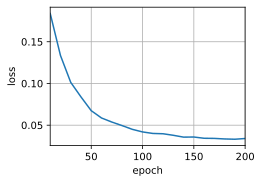

In [34]:
# 这行代码将一些变量进行初始化赋值。num_hiddens被赋值为32，num_layers被赋值为2，dropout被赋值为0.1，batch_size被赋值为64，num_steps被赋值为10。
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
# 这行代码类似于第一行，将一些变量进行初始化赋值。lr被赋值为0.005，num_epochs被赋值为200，device被赋值为d2l.try_gpu()的返回值。d2l.try_gpu()是一个函数，用于尝试使用GPU设备，如果可用的话。
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
# 同样是将一些变量进行初始化赋值。ffn_num_input被赋值为32，ffn_num_hiddens被赋值为64，num_heads被赋值为4。
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
# 再次进行变量初始化赋值。key_size被赋值为32，query_size被赋值为32，value_size被赋值为32。
key_size, query_size, value_size = 32, 32, 32
# 将一个列表赋值给norm_shape变量。该列表只包含一个元素32。
norm_shape = [32]

# 这行代码调用d2l.load_data_nmt()函数，并将返回的结果分别赋值给train_iter、src_vocab和tgt_vocab变量。
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

# 创建一个TransformerEncoder对象，并将其赋值给encoder变量。该对象的构造函数接受多个参数，并使用提供的参数进行初始化。
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
# 创建一个TransformerDecoder对象，并将其赋值给decoder变量。同样，该对象的构造函数接受多个参数，并使用提供的参数进行初始化。
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
# 创建一个EncoderDecoder对象，并将其赋值给net变量。该对象接受一个编码器对象和一个解码器对象作为参数，并将其组合成一个编码-解码器模型。
net = d2l.EncoderDecoder(encoder, decoder)
# 调用d2l.train_seq2seq()函数，传入net、train_iter、lr、num_epochs、tgt_vocab和device作为参数，进行序列到序列模型的训练。
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

训练结束后，使用Transformer模型[**将一些英语句子翻译成法语**]，并且计算它们的BLEU分数。


In [35]:
# 这行代码定义了一个名为engs的列表，其中包含了4个英文句子。
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
# 这行代码定义了一个名为fras的列表，其中包含了4个法文句子，与engs中的句子一一对应。
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
# 这是一个循环语句，用于迭代engs和fras两个列表中的元素。在每次迭代中，将engs和fras中相应位置的元素分别赋值给变量eng和fra。
for eng, fra in zip(engs, fras):
    # 这行代码调用了d2l.predict_seq2seq()函数，传入了一些参数，并将返回的结果分别赋值给translation和dec_attention_weight_seq变量。该函数用于进行序列到序列模型的预测，返回预测的翻译结果和解码器的注意力权重序列。
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    # 这行代码用于打印输出翻译结果和BLEU得分。使用了f-string格式化字符串的方式，将eng、translation、fra和BLEU得分格式化为字符串并打印出来。
    # 其中，d2l.bleu()函数用于计算BLEU得分，传入了预测的翻译结果translation、目标法文句子fra和参数k=2表示使用2-gram的精确匹配度量。
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est riche .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


当进行最后一个英语到法语的句子翻译工作时，让我们[**可视化Transformer的注意力权重**]。编码器自注意力权重的形状为（编码器层数，注意力头数，`num_steps`或查询的数目，`num_steps`或“键－值”对的数目）。


In [36]:
# enc_attention_weights = torch.cat(net.encoder.attention_weights, 0)：这行代码将net.encoder.attention_weights中的元素进行拼接，沿着0维度进行拼接，
# 得到一个新的张量enc_attention_weights。net.encoder.attention_weights是一个列表，其中包含了编码器中每个注意力头的注意力权重。拼接操作将这些注意力权重张量按照0维度进行拼接。

# reshape((num_layers, num_heads, -1, num_steps))：这行代码对enc_attention_weights进行形状重塑（reshape）操作，
# 将其形状变为(num_layers, num_heads, -1, num_steps)。其中num_layers表示编码器的层数，num_heads表示注意力头的数量，-1表示该维度的大小会根据其他维度的大小自动推断，num_steps表示序列的长度。
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))

# enc_attention_weights.shape：这行代码返回enc_attention_weights张量的形状。
enc_attention_weights.shape

# 综上所述，给定编码器的注意力权重列表net.encoder.attention_weights，通过拼接和形状重塑操作，得到了一个形状为(num_layers, num_heads, -1, num_steps)的张量enc_attention_weights。
# 这个张量可以用于分析编码器在不同层、不同头和不同位置上的注意力分布情况。

torch.Size([2, 4, 10, 10])

在编码器的自注意力中，查询和键都来自相同的输入序列。因为填充词元是不携带信息的，因此通过指定输入序列的有效长度可以避免查询与使用填充词元的位置计算注意力。接下来，将逐行呈现两层多头注意力的权重。每个注意力头都根据查询、键和值的不同的表示子空间来表示不同的注意力。


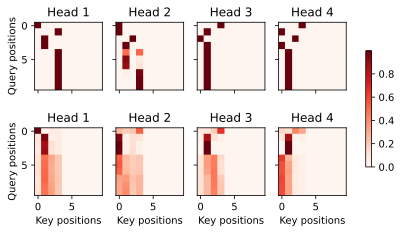

In [37]:
# d2l.show_heatmaps(：这是一个函数调用语句，调用了名为d2l.show_heatmaps的函数。该函数用于显示热图（heatmaps）。
# enc_attention_weights.cpu()：这是函数调用中的第一个参数，表示将enc_attention_weights张量移动到CPU上进行处理。.cpu()是PyTorch中的方法，用于将张量移动到CPU设备。
# xlabel='Key positions'：这是函数调用中的第二个参数，设置x轴标签为"Key positions"。
# ylabel='Query positions'：这是函数调用中的第三个参数，设置y轴标签为"Query positions"。
# ylabel='Query positions'：这是函数调用中的第三个参数，设置y轴标签为"Query positions"。
# figsize=(7, 3.5)：这是函数调用中的第五个参数，设置图形的尺寸为宽度7和高度3.5。
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))
# 综上所述，给定编码器的注意力权重张量enc_attention_weights，通过d2l.show_heatmaps函数将其可视化为热图。
# 在可视化过程中，设置了x轴标签、y轴标签、热图标题和图形尺寸。热图将展示编码器中不同层、不同头、不同位置的注意力分布情况。

[**为了可视化解码器的自注意力权重和“编码器－解码器”的注意力权重，我们需要完成更多的数据操作工作。**]例如用零填充被掩蔽住的注意力权重。值得注意的是，解码器的自注意力权重和“编码器－解码器”的注意力权重都有相同的查询：即以*序列开始词元*（beginning-of-sequence,BOS）打头，再与后续输出的词元共同组成序列。


In [38]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

由于解码器自注意力的自回归属性，查询不会对当前位置之后的“键－值”对进行注意力计算。


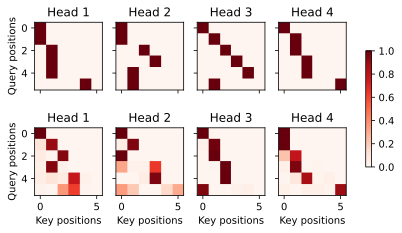

In [39]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

与编码器的自注意力的情况类似，通过指定输入序列的有效长度，[**输出序列的查询不会与输入序列中填充位置的词元进行注意力计算**]。


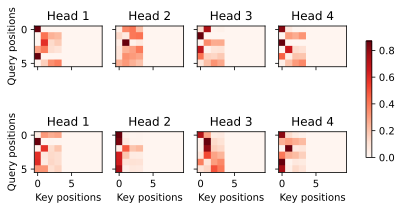

In [40]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

尽管Transformer架构是为了*序列到序列*的学习而提出的，但正如本书后面将提及的那样，Transformer编码器或Transformer解码器通常被单独用于不同的深度学习任务中。

## 小结

* Transformer是编码器－解码器架构的一个实践，尽管在实际情况中编码器或解码器可以单独使用。
* 在Transformer中，多头自注意力用于表示输入序列和输出序列，不过解码器必须通过掩蔽机制来保留自回归属性。
* Transformer中的残差连接和层规范化是训练非常深度模型的重要工具。
* Transformer模型中基于位置的前馈网络使用同一个多层感知机，作用是对所有序列位置的表示进行转换。

## 练习

1. 在实验中训练更深的Transformer将如何影响训练速度和翻译效果？
1. 在Transformer中使用加性注意力取代缩放点积注意力是不是个好办法？为什么？
1. 对于语言模型，应该使用Transformer的编码器还是解码器，或者两者都用？如何设计？
1. 如果输入序列很长，Transformer会面临什么挑战？为什么？
1. 如何提高Transformer的计算速度和内存使用效率？提示：可以参考论文 :cite:`Tay.Dehghani.Bahri.ea.2020`。
1. 如果不使用卷积神经网络，如何设计基于Transformer模型的图像分类任务？提示：可以参考Vision Transformer :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021`。


[Discussions](https://discuss.d2l.ai/t/5756)
